In [ ]:
# Install system dependencies for Box2D and Video Recording
!apt-get install -y swig ffmpeg xvfb
# Install Python libraries
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay

import gymnasium as gym
import os
import base64
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML

# --- COLAB SETUP ---
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Create Virtual Display (Required for video in Colab)
display = Display(visible=0, size=(1400, 900))
display.start()

# --- CONFIGURATION ---
EXPERIMENT_NAME = "basic_ppo_final"
ENV_ID = "BipedalWalker-v3"
TOTAL_TIMESTEPS = 2_000_000    # 2 Million Steps
NUM_CPU = 4                    # Colab usually gives 2-4 cores. 4 is a safe bet.
SEED = 42

# --- DIRECTORY SETUP (GOOGLE DRIVE) ---
# This saves everything to "My Drive/aisf_project/..."
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

def make_env(rank, seed=0):
    """
    Utility function for multiprocessed env.
    """
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (Steps: {TOTAL_TIMESTEPS}) ---")
    print(f"Saving data to: {base_path}")

    # 1. Create Multiprocessed Environment (FAST)
    env = SubprocVecEnv([make_env(i) for i in range(NUM_CPU)])

    # Wrap in VecMonitor to log the reward data for your graphs
    env = VecMonitor(env, log_dir)

    # 2. Setup Callback
    # Saves the best model found during training to Drive
    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=max(10000 // NUM_CPU, 1),
        deterministic=True,
        render=False
    )

    # 3. Create Model
    # "Untuned" - using default hyperparameters (matches "No clipping or penalty" baseline concept [cite: 557])
    # though SB3 defaults usually include some clipping.
    model = PPO("MlpPolicy", env, verbose=1, seed=SEED, tensorboard_log=log_dir)

    # 4. Train
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

    model.save(f"{model_dir}/final_model")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    # Try to load the best model (if EvalCallback saved one), otherwise final
    best_model_path = os.path.join(model_dir, "best_model.zip")
    if not os.path.exists(best_model_path):
        print("Best model not found, loading final model.")
        best_model_path = os.path.join(model_dir, "final_model.zip")

    model = PPO.load(best_model_path)

    # Use DummyVecEnv for video recording (simpler than Subproc)
    from stable_baselines3.common.vec_env import DummyVecEnv
    video_env = DummyVecEnv([lambda: gym.make(ENV_ID, render_mode="rgb_array")])

    # Record 1 episode or max 1600 steps
    video_env = VecVideoRecorder(
        video_env,
        video_dir,
        record_video_trigger=lambda x: x == 0, # Record immediately
        video_length=1600,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    # --- DISPLAY IN COLAB ---
    # Finds the video file we just made and displays it
    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        print(f"Video saved to: {mp4}")

        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 1 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,784 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.d

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Starting Training: basic_ppo_final (Steps: 2000000) ---
Saving data to: /content/drive/MyDrive/aisf_project
Using cpu device
Logging to /content/drive/MyDrive/aisf_project/logs/basic_ppo_final/PPO_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.43        |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.00269    |
|    std                  | 0.493       |
|    value_loss           | 12.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | 112      |
| time/              |          |
|    fps             | 812      |
|    iterations      | 76       |
|    time_elapsed    | 766      |
|    total_timesteps | 622592   |
---------------------------------
Eval num_timesteps=630000, episode_reward=156.89 +/- 141.93
Episode length: 1214.40 +/- 531.14
-----------------------------------------
| eval/                   |             |
|    mean_

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_r

Moviepy - Building video /content/drive/MyDrive/aisf_project/videos/basic_ppo_final/basic_ppo_final_agent-step-0-to-step-1600.mp4.
Moviepy - Writing video /content/drive/MyDrive/aisf_project/videos/basic_ppo_final/basic_ppo_final_agent-step-0-to-step-1600.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/basic_ppo_final/basic_ppo_final_agent-step-0-to-step-1600.mp4
Video saved to: /content/drive/MyDrive/aisf_project/videos/basic_ppo_final/basic_ppo_final_agent-step-0-to-step-1600.mp4


TypeError: 'Display' object is not callable

In [ ]:
import gymnasium as gym
import os
import numpy as np
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive # Added for Drive saving
from typing import Callable
import base64
from IPython.display import HTML, display as ipy_display # Explicit import to be safe
from pyvirtualdisplay import Display

# --- COLAB SETUP ---
# 1. Mount Drive (CRITICAL for saving logs)
drive.mount('/content/drive')

# 2. Virtual Display (Renamed to avoid conflict)
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# --- CONFIGURATION ---
EXPERIMENT_NAME = "improved_ppo_v2"
ENV_ID = "BipedalWalker-v3"
TOTAL_TIMESTEPS = 2_000_000
NUM_CPU = 4
SEED = 42

# --- DIRECTORY SETUP (DRIVE) ---
# Saves directly to your Google Drive
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- IMPROVEMENT C: REWARD SHAPING (Wrapper) ---
class EncouragingWalkerWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        # Scale reward to offset the torque penalty slightly
        return reward * 1.1

# --- IMPROVEMENT B: LEARNING RATE SCHEDULE ---
# Linearly anneal from initial_value to 0
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env(rank, seed=0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = EncouragingWalkerWrapper(env)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} ---")
    print(f"Saving to: {base_path}")

    # 1. Parallel Environments
    env = SubprocVecEnv([make_env(i) for i in range(NUM_CPU)])
    env = VecMonitor(env, log_dir)

    # --- IMPROVEMENT A: OBSERVATION NORMALIZATION ---
    # Standard practice for continuous control
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    # 2. Callbacks
    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=max(20000 // NUM_CPU, 1),
        deterministic=True,
        render=False
    )

    # 3. Model with Literature Hyperparameters (Schulman et al. 2017)
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        # Architecture: 2 hidden layers of 64 units, Tanh activation
        policy_kwargs=dict(
            net_arch=[64, 64],
            activation_fn=nn.Tanh
        ),
        # PPO Hyperparameters
        learning_rate=linear_schedule(3e-4),
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.001,
        vf_coef=0.5,
        max_grad_norm=0.5,
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vecnormalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vecnormalize.pkl")

    if not os.path.exists(model_path):
        model_path = os.path.join(model_dir, "final_model.zip")

    # Recreate Environment
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = EncouragingWalkerWrapper(env)

    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Load Stats
    env = VecNormalize.load(stats_path, env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(model_path)

    # Record
    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=1600,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    # --- DISPLAY IN COLAB ---
    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Starting Training: improved_ppo_v2 ---
Saving to: /content/drive/MyDrive/aisf_project


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    clip_range           | 0.2         |
|    entropy_loss         | -3.23       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.000237    |
|    loss                 | -0.00222    |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0144     |
|    std                  | 0.543       |
|    value_loss           | 0.002       |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.5e+03  |
|    ep_rew_mean     | 209      |
| time/              |          |
|    fps             | 706      |
|    iterations      | 52       |
|    time_elapsed    | 602      |
|    total_timesteps | 425984   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.52e+03    |
|    ep_rew_mean          | 217         |

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/improved_ppo_v2/improved_ppo_v2_agent-step-0-to-step-1600.mp4


In [ ]:
import gymnasium as gym
import os
import numpy as np
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from typing import Callable
import base64
from IPython.display import HTML, display as ipy_display
from pyvirtualdisplay import Display

# --- COLAB SETUP ---
# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Virtual Display (Prevent "Display not callable" error)
try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION ---
# Note: Distinct name to separate from Normal difficulty logs
EXPERIMENT_NAME = "improved_ppo_v2_hardcore"
ENV_ID = "BipedalWalkerHardcore-v3"  # <--- HARDCORE MODE
TOTAL_TIMESTEPS = 3_000_000          # 3M Budget (Fair limit for ablation)
NUM_CPU = 4
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- REWARD SHAPING ---
class EncouragingWalkerWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, reward):
        # Slightly increase reward to encourage trying new things despite failure
        return reward * 1.1

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env(rank, seed=0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = EncouragingWalkerWrapper(env)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (HARDCORE) ---")
    print(f"Saving to: {base_path}")

    env = SubprocVecEnv([make_env(i) for i in range(NUM_CPU)])
    env = VecMonitor(env, log_dir)

    # Normalization is CRITICAL for Hardcore (lidar values vary wildly)
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=max(20000 // NUM_CPU, 1),
        deterministic=True,
        render=False
    )

    # Using PPO V2 Config (Improved Baseline)
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=dict(
            net_arch=[64, 64],
            activation_fn=nn.Tanh
        ),
        learning_rate=linear_schedule(3e-4),
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.001,
        vf_coef=0.5,
        max_grad_norm=0.5,
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vecnormalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vecnormalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = EncouragingWalkerWrapper(env)

    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Load Stats
    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("Warning: Normalization stats not found!")

    model = PPO.load(best_model_path)

    # Record longer for Hardcore (it takes time to cross pitfalls)
    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Streaming output truncated to the last 5000 lines.
-----------------------------------------
Eval num_timesteps=1420000, episode_reward=-26.79 +/- 58.70
Episode length: 1437.00 +/- 726.85
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 1.44e+03  |
|    mean_reward          | -26.8     |
| time/                   |           |
|    total_timesteps      | 1420000   |
| train/                  |           |
|    approx_kl            | 0.0251822 |
|    clip_fraction        | 0.243     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.14     |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000158  |
|    loss                 | 0.0312    |
|    n_updates            | 1730      |
|    policy_gradient_loss | -0.0278   |
|    std                  | 0.322     |
|    value_loss           | 0.181     |
---------------------------------------
New best mean reward!
------------------------------

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/improved_ppo_v2_hardcore/improved_ppo_v2_hardcore_agent-step-0-to-step-2000.mp4


In [ ]:
import gymnasium as gym
import os
import base64
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Virtual Display (Renamed to avoid conflict)
try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION ---
EXPERIMENT_NAME = "sota_ppo_v3_hardcore"
ENV_ID = "BipedalWalkerHardcore-v3"  # <--- CRITICAL UPDATE FOR HARDCORE
TOTAL_TIMESTEPS = 3_000_000          # 3M Budget (Matches your V2 run)
NUM_CPU = 4
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- REWARD SHAPING ---
class EncouragingWalkerWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    def reward(self, reward):
        return reward * 1.1

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env(rank, seed=0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = EncouragingWalkerWrapper(env)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (SOTA HARDCORE) ---")
    print(f"Saving to: {base_path}")

    env = SubprocVecEnv([make_env(i) for i in range(NUM_CPU)])
    env = VecMonitor(env, log_dir)

    # Normalization (CRITICAL for Hardcore)
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=max(20000 // NUM_CPU, 1),
        deterministic=True,
        render=False
    )

    # 4. SOTA PPO Model
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,

        # --- SOTA IMPROVEMENTS ---
        use_sde=True,           # 1. gSDE Exploration (Key for Hardcore)
        policy_kwargs=dict(
            # 2. Separate Networks & Increased Size [256, 256]
            net_arch=dict(pi=[256, 256], vf=[256, 256]),
            activation_fn=nn.Tanh,
            # 3. Adam Optimizer Tweak
            optimizer_kwargs=dict(eps=1e-5)
        ),

        # Hyperparameters (Tuned for Power)
        learning_rate=linear_schedule(3e-4),
        n_steps=2048,
        batch_size=1024,        # 4. Larger Batch Size
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.001,
        vf_coef=0.5,
        max_grad_norm=0.5,
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vecnormalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vecnormalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = EncouragingWalkerWrapper(env)

    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Load Stats
    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("Warning: Normalization stats not found!")

    model = PPO.load(best_model_path)

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

--- Starting Training: sota_ppo_v3_hardcore (SOTA HARDCORE) ---
Saving to: /content/drive/MyDrive/aisf_project
Using cpu device
Logging to /content/drive/MyDrive/aisf_project/logs/sota_ppo_v3_hardcore/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 67.5     |
|    ep_rew_mean     | -121     |
| time/              |          |
|    fps             | 1625     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 83.6       |
|    ep_rew_mean          | -127       |
| time/                   |            |
|    fps                  | 1428       |
|    iterations           | 2          |
|    time_elapsed         | 11         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.06825566 |
| 

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import os
import base64
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION: V3.1 (SOTA Config BUT Standard Noise) ---
EXPERIMENT_NAME = "sota_ppo_v3_1_hardcore"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 3_000_000
NUM_CPU = 4
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- REWARD SHAPING ---
class EncouragingWalkerWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    def reward(self, reward):
        return reward * 1.1

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env(rank, seed=0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = EncouragingWalkerWrapper(env)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (Big Net, No gSDE) ---")
    print(f"Saving to: {base_path}")

    env = SubprocVecEnv([make_env(i) for i in range(NUM_CPU)])
    env = VecMonitor(env, log_dir)

    # Normalization (Mandatory for Hardcore)
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=max(20000 // NUM_CPU, 1),
        deterministic=True,
        render=False
    )

    # 4. SOTA PPO Model (Modified V3.1)
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,

        # --- KEY CHANGE: DISABLE gSDE ---
        use_sde=False,          # <--- V3.1 Change: Standard Noise for "Twitch" reactivity

        policy_kwargs=dict(
            # Keep the SOTA Architecture [256, 256] Separate
            net_arch=dict(pi=[256, 256], vf=[256, 256]),
            activation_fn=nn.Tanh,
            optimizer_kwargs=dict(eps=1e-5)
        ),

        # Keep SOTA Hyperparameters
        learning_rate=linear_schedule(3e-4),
        n_steps=2048,
        batch_size=1024,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.001,
        vf_coef=0.5,
        max_grad_norm=0.5,
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vecnormalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vecnormalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = EncouragingWalkerWrapper(env)

    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("Warning: Normalization stats not found!")

    model = PPO.load(best_model_path)

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.204        |
------------------------------------------
Eval num_timesteps=1420000, episode_reward=-56.01 +/- 51.00
Episode length: 591.20 +/- 714.43
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 591         |
|    mean_reward          | -56         |
| time/                   |             |
|    total_timesteps      | 1420000     |
| train/                  |             |
|    approx_kl            | 0.008916704 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000158    |
|    loss                 | -0.0211     |
|    n_updates            | 1730        |
|    policy_gradient_loss | -0.0191     |
|    std                  | 0.635       |
|    value_loss           | 0.0468      |
-------------

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/sota_ppo_v3_1_hardcore/sota_ppo_v3_1_hardcore_agent-step-0-to-step-2000.mp4


In [ ]:
!pip install sb3-contrib
import gymnasium as gym
import os
import torch.nn as nn
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION (Zoo Tuned) ---
EXPERIMENT_NAME = "tqc_hardcore_zoo_tuned"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 3_000_000
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- LINEAR SCHEDULE (Matches Zoo 'lin_7.3e-4') ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env():
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = Monitor(env, log_dir)
    return env

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (Zoo Config) ---")

    env = DummyVecEnv([make_env])

    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=25_000, # TQC is slower per step, check less often
        deterministic=True,
        render=False
    )

    # --- TQC HYPERPARAMETERS (From RL Zoo) ---
    policy_kwargs = dict(
        n_critics=2,
        n_quantiles=25,
        net_arch=[400, 300], # Zoo Architecture
    )

    model = TQC(
        "MlpPolicy",
        env,
        top_quantiles_to_drop_per_net=2,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=policy_kwargs,

        # Zoo Tuning:
        learning_rate=linear_schedule(7.3e-4), # Matches 'lin_7.3e-4'
        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.01,              # Faster updates than standard
        train_freq=1,
        gradient_steps=1,
        learning_starts=10_000,
        use_sde=False          # Zoo default is usually False for Hardcore
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=1000)

    model.save(f"{model_dir}/final_model")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    model = TQC.load(best_model_path)

    env = gym.make(ENV_ID, render_mode="rgb_array")
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.9 MB/s eta 0:00:00
--- Starting Training: tqc_hardcore_zoo_tuned (Zoo Config) ---
Using cpu device
Logging to /content/drive/MyDrive/aisf_project/logs/tqc_hardcore_zoo_tuned/TQC_1
Eval num_timesteps=25000, episode_reward=-110.23 +/- 0.23
Episode length: 48.60 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 48.6     |
|    mean_reward     | -110     |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -7.31    |
|    critic_loss     | 0.19     |
|    ent_coef        | 0.00543  |
|    ent_coef_loss   | -1.1     |
|    learning_rate   | 0.000724 |
|    n_updates       | 14999    |
---------------------------------
New best mean reward!
Eval num_timesteps=50000, episode_reward=-91.57 +/- 15.09
Episode length: 505.40 +/- 747.62
---------------------------------
| eval/              |          |
|    mean_ep_l

KeyboardInterrupt: 

In [ ]:
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib
import gymnasium as gym
import os
import torch.nn as nn
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION (Zoo Tuned + GPU) ---
EXPERIMENT_NAME = "tqc_hardcore_zoo_tuned_gpu" # <--- New name to avoid conflicts
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 3_000_000
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env():
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = Monitor(env, log_dir)
    return env

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (GPU Powered) ---")
    print(f"Logs will be saved to: {log_dir}")

    # Check if GPU is available
    import torch
    if torch.cuda.is_available():
        print(f"SUCCESS: Training on {torch.cuda.get_device_name(0)}")
    else:
        print("WARNING: GPU not detected. Go to Runtime > Change runtime type > T4 GPU")

    env = DummyVecEnv([make_env])

    eval_callback = EvalCallback(
        env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=25_000,
        deterministic=True,
        render=False
    )

    # --- TQC HYPERPARAMETERS (Zoo) ---
    policy_kwargs = dict(
        n_critics=2,
        n_quantiles=25,
        net_arch=[400, 300],
    )

    model = TQC(
        "MlpPolicy",
        env,
        top_quantiles_to_drop_per_net=2,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=policy_kwargs,

        # Zoo Tuning:
        learning_rate=linear_schedule(7.3e-4),
        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.01,
        train_freq=1,
        gradient_steps=1,
        learning_starts=10_000,
        use_sde=False
    )

    # Lowered log_interval to 100 so you see updates faster
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=100)

    model.save(f"{model_dir}/final_model")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    model = TQC.load(best_model_path)

    env = gym.make(ENV_ID, render_mode="rgb_array")
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (900 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.de

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Starting Training: tqc_hardcore_zoo_tuned_gpu (GPU Powered) ---
Logs will be saved to: /content/drive/MyDrive/aisf_project/logs/tqc_hardcore_zoo_tuned_gpu
SUCCESS: Training on Tesla T4


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging to /content/drive/MyDrive/aisf_project/logs/tqc_hardcore_zoo_tuned_gpu/TQC_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=25000, episode_reward=-89.88 +/- 31.15
Episode length: 1703.60 +/- 592.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.7e+03  |
|    mean_reward     | -89.9    |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -6.2     |
|    critic_loss     | 0.237    |
|    ent_coef        | 0.00544  |
|    ent_coef_loss   | -1.98    |
|    learning_rate   | 0.000724 |
|    n_updates       | 14999    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 461      |
|    ep_rew_mean     | -110     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 99       |
|    time_elapsed    | 483      |
|    total_timesteps | 47892    |
| train/             |          |
|    actor_loss      | -3.37    |
|    critic_loss     | 0.218    |
|

KeyboardInterrupt: 

In [ ]:
# Install dependencies
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib

import gymnasium as gym
import os
import torch
import numpy as np
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, VecVideoRecorder
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION (The "Ultimate" Hybrid) ---
EXPERIMENT_NAME = "tqc_hardcore_ultimate"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 3_000_000
NUM_CPU = 4  # Matches your fast code
SEED = 42

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- LINEAR SCHEDULE (Zoo Trick) ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

def make_env(rank: int, seed: int = 0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = Monitor(env, log_dir)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} ---")
    print(f"Hardware: {'GPU' if torch.cuda.is_available() else 'CPU'}")

    # 1. PARALLELISM (Speed)
    env = SubprocVecEnv([make_env(i, SEED) for i in range(NUM_CPU)])
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    # 2. SEPARATE EVAL ENV (Accuracy)
    eval_env = SubprocVecEnv([make_env(999, SEED)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    eval_env.training = False

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=50_000,
        deterministic=True,
        render=False
    )

    # 3. ZOO HYPERPARAMETERS (Intelligence)
    # These specific numbers are from the RL Zoo benchmark for Hardcore
    policy_kwargs = dict(
        n_critics=2,
        n_quantiles=25,
        net_arch=[400, 300], # Bigger network than your previous run
    )

    model = TQC(
        "MlpPolicy",
        env,
        top_quantiles_to_drop_per_net=2,
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=policy_kwargs,

        # --- The Hybrid Optimization ---
        # 1. High LR (from Zoo)
        learning_rate=linear_schedule(7.3e-4),

        # 2. Batched Updates (from your Fast Code)
        # This is CRITICAL for speed. Do not change this to 1.
        train_freq=64,
        gradient_steps=64,

        # 3. Forced Entropy (Inspired by your code)
        # "auto_0.05" is technically "auto" with init value 0.05.
        # Standard "auto" is safer for TQC, but we rely on the high LR here.
        ent_coef="auto",

        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.01, # Faster target updates (Zoo style)
        use_sde=False
    )

    # 4. TRAIN (With frequent logs)
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=50)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vec_normalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vec_normalize.pkl")

    # Fallback to final model if best not saved yet
    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    # Recreate Eval Environment
    # We use DummyVecEnv for video recording compatibility
    env = SubprocVecEnv([make_env(0, SEED)])
    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("WARNING: Normalization stats not found. Video agent will likely fail.")

    model = TQC.load(best_model_path)

    # Use VecVideoRecorder
    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    # Depending on SB3 version, VecEnv reset returns only obs
    # but Gymnasium returns (obs, info). SB3 wrappers usually handle this.
    # If using VecEnv, done is a boolean array.

    # Run simulation
    step_count = 0
    while step_count < 2000:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, dones, _ = video_env.step(action)
        step_count += 1
        if any(dones):
             break

    video_env.close()

    # Display
    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (481 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.de

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Starting Training: tqc_hardcore_ultimate ---
Hardware: GPU
Using cuda device
Logging to /content/drive/MyDrive/aisf_project/logs/tqc_hardcore_ultimate/TQC_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 444      |
|    ep_rew_mean     | -121     |
| time/              |          |
|    episodes        | 50       |
|    fps             | 302      |
|    time_elapsed    | 87       |
|    total_timesteps | 26400    |
| train/             |          |
|    actor_loss      | -18.1    |
|    critic_loss     | 0.0332   |
|    ent_coef        | 0.0111   |
|    ent_coef_loss   | -16.6    |
|    learning_rate   | 0.000724 |
|    n_updates       | 6592     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 409      |
|    ep_rew_mean     | -123     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 304      |
|    time_elapsed    | 135      |
|    total_timesteps | 41348    |
| train/             |          |
|    actor_loss      | -12.1    |
|    critic_loss     | 0.0321   |
|    ent_coef 

KeyboardInterrupt: 

In [ ]:
import warnings
# Ignore all DeprecationWarnings so the logs are clean
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Install dependencies if you restarted the runtime
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib

import gymnasium as gym
import os
import torch
import numpy as np
import base64
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION ---
# CHANGED: Updated version number to v3 to prevent conflict
EXPERIMENT_NAME = "tqc_v3_hardcore"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 3_000_000
SEED = 42
NUM_CPU = 4  # Keep 4 CPUs for data collection speed

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

# --- ENVIRONMENT MAKER ---
def make_env(rank: int, seed: int = 0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = Monitor(env, log_dir)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (Balanced Mode) ---")

    # 1. PARALLEL ENVIRONMENTS (Speed)
    env = SubprocVecEnv([make_env(i, SEED) for i in range(NUM_CPU)])

    # 2. NORMALIZATION (Stability for Hardcore)
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    # Eval Env
    eval_env = SubprocVecEnv([make_env(999, SEED)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    eval_env.training = False

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=50_000,
        deterministic=True,
        render=False
    )

    # --- TQC v2 CONFIGURATION ---
    policy_kwargs = dict(
        n_critics=2,            # Kept at 2 for SPEED
        n_quantiles=25,         # 25 Atoms
        net_arch=[400, 300],    # Zoo Architecture (Stronger than 256, faster than 512)
    )

    model = TQC(
        "MlpPolicy",
        env,
        top_quantiles_to_drop_per_net=2, # Drop top 2 atoms per critic (Safety)
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=policy_kwargs,

        # --- TUNING ---
        learning_rate=linear_schedule(7.3e-4), # Fast Zoo Learning Rate
        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.01,

        # --- SPEED & SAFETY ---
        train_freq=64,         # Batched Collection (Fast CPU)
        gradient_steps=64,     # Batched Updates (Fast GPU)
        learning_starts=10_000,
        use_sde=False          # Standard noise for reactivity
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=100)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vec_normalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vec_normalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    # Use DummyVecEnv for recording (Compatibility)
    env = DummyVecEnv([make_env(0, SEED)])

    # Load Stats
    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("Warning: Normalization stats not found!")

    model = TQC.load(best_model_path)

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)
        # Fix for vector environment returning array of dones
        if isinstance(done, (list, np.ndarray)):
             done = done[0]

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--- Starting Training: tqc_v3_hardcore (Balanced Mode) ---
Using cuda device
Logging to /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore/TQC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03e+03 |
|    ep_rew_mean     | -118     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 334      |
|    time_elapsed    | 312      |
|    total_timesteps | 104392   |
| train/             |          |
|    actor_loss      | -2.97    |
|    critic_loss     | 0.00307  |
|    ent_coef        | 0.000429 |
|    ent_coef_loss   | 0.214    |
|    learning_rate   | 0.00

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore/tqc_v3_hardcore_agent-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore/tqc_v3_hardcore_agent-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore/tqc_v3_hardcore_agent-step-0-to-step-2000.mp4


In [ ]:
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib
import gymnasium as gym
import os
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION ---
# We use a new name to keep the logs separate, but we LOAD the old model
LOAD_FROM_EXPERIMENT = "tqc_v3_hardcore"
EXPERIMENT_NAME = "tqc_v3_hardcore_finetune"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 2_000_000  # 2M extra steps to polish the score
NUM_CPU = 4

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"
load_model_path = f"{base_path}/models/{LOAD_FROM_EXPERIMENT}/best_model.zip"
load_stats_path = f"{base_path}/models/{LOAD_FROM_EXPERIMENT}/vec_normalize.pkl"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

def make_env(rank: int, seed: int = 0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = Monitor(env, log_dir)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Resuming Training: {EXPERIMENT_NAME} ---")

    # 1. Setup Environment
    env = SubprocVecEnv([make_env(i, 42) for i in range(NUM_CPU)])

    # 2. Load Normalization Stats (CRITICAL)
    # We must start with the stats (mean/std) the agent learned previously
    print(f"Loading normalization stats from: {load_stats_path}")
    env = VecNormalize.load(load_stats_path, env)
    env.training = True # Keep updating stats
    env.norm_reward = True

    # 3. Setup Eval
    eval_env = SubprocVecEnv([make_env(999, 42)])
    eval_env = VecNormalize.load(load_stats_path, eval_env)
    eval_env.training = False

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=25_000,
        deterministic=True,
        render=False
    )

    # 4. Load the Pre-Trained Model
    print(f"Loading model from: {load_model_path}")
    # custom_objects argument lets us overwrite the learning rate!
    # We set it to a constant low value (5e-5) to fine-tune.
    model = TQC.load(
        load_model_path,
        env=env,
        custom_objects={"learning_rate": 5e-5, "learning_starts": 0},
        print_system_info=True
    )

    # 5. Train
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=100)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vec_normalize.pkl")
    print("Fine-tuning finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Final Video ---")

    # Load Best Model from the NEW finetune folder
    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vec_normalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    model = TQC.load(best_model_path)

    # Video Env
    env = DummyVecEnv([make_env(0, 42)])
    env = VecNormalize.load(stats_path, env)
    env.training = False
    env.norm_reward = False

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2500, # Longer video to catch the win
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (538 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.de

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Resuming Training: tqc_v3_hardcore_finetune ---
Loading normalization stats from: /content/drive/MyDrive/aisf_project/models/tqc_v3_hardcore/vec_normalize.pkl
Loading model from: /content/drive/MyDrive/aisf_project/models/tqc_v3_hardcore/best_model.zip
== CURRENT SYSTEM INFO ==
- OS: Linux-6.6.105+-x86_64-with-glibc2.35 # 1 SMP Thu Oct  2 10:42:05 UTC 2025
- Python: 3.12.12
- Stable-Baselines3: 2.7.1
- PyTorch: 2.9.0+cu126
- GPU Enabled: True
- Numpy: 2.0.2
- Cloudpickle: 3.1.2
- Gymnasium: 1.2.2
- OpenAI Gym: 0.25.2

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-6.6.105+-x86_64-with-glibc2.35 # 1 SMP Thu Oct  2 10:42:05 UTC 2025
- Python: 3.12.12
- Stable-Baselines3: 2.7.1
- PyTorch: 2.9.0+cu126
- GPU Enabled: True
- Numpy: 2.0.2
- Cloudpickle: 3.1.2
- Gymnasium: 1.2.2
- OpenAI Gym: 0.25.2

Logging to /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore/TQC_2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=100000, episode_reward=111.91 +/- 160.77
Episode length: 1020.20 +/- 662.51
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.02e+03 |
|    mean_reward     | 112      |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -0.587   |
|    critic_loss     | 0.00157  |
|    ent_coef        | 0.000904 |
|    ent_coef_loss   | 0.136    |
|    learning_rate   | 5e-05    |
|    n_updates       | 722432   |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16e+03 |
|    ep_rew_mean     | 106      |
| time/              |          |
|    episodes        | 100      |
|    fps             | 288      |
|    time_elapsed    | 408      |
|    total_timesteps | 117692   |
| train/             |          |
|    actor_loss      | -0.565   |
|    critic_loss     | 0.00185  |

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Moviepy - Building video /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore_finetune/tqc_v3_hardcore_finetune_agent-step-0-to-step-2500.mp4.
Moviepy - Writing video /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore_finetune/tqc_v3_hardcore_finetune_agent-step-0-to-step-2500.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore_finetune/tqc_v3_hardcore_finetune_agent-step-0-to-step-2500.mp4


NameError: name 'base64' is not defined

In [ ]:
# Install dependencies if you restarted the runtime
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib

import gymnasium as gym
import os
import torch
import numpy as np
import base64
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from google.colab import drive
from pyvirtualdisplay import Display
from IPython.display import HTML, display as ipy_display
from typing import Callable

# --- COLAB SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

try:
    virtual_display
except NameError:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

# --- CONFIGURATION ---
# CHANGED: Updated version number to v3 to prevent conflict
EXPERIMENT_NAME = "tqc_v3_hardcore_5M"
ENV_ID = "BipedalWalkerHardcore-v3"
TOTAL_TIMESTEPS = 5_000_000
SEED = 42
NUM_CPU = 4  # Keep 4 CPUs for data collection speed

# --- DIRECTORY SETUP ---
base_path = "/content/drive/MyDrive/aisf_project"
log_dir = f"{base_path}/logs/{EXPERIMENT_NAME}"
model_dir = f"{base_path}/models/{EXPERIMENT_NAME}"
video_dir = f"{base_path}/videos/{EXPERIMENT_NAME}"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# --- LINEAR SCHEDULE ---
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

# --- ENVIRONMENT MAKER ---
def make_env(rank: int, seed: int = 0):
    def _init():
        env = gym.make(ENV_ID, render_mode="rgb_array")
        env = Monitor(env, log_dir)
        env.reset(seed=seed + rank)
        return env
    return _init

def train():
    print(f"--- Starting Training: {EXPERIMENT_NAME} (Balanced Mode) ---")

    # 1. PARALLEL ENVIRONMENTS (Speed)
    env = SubprocVecEnv([make_env(i, SEED) for i in range(NUM_CPU)])

    # 2. NORMALIZATION (Stability for Hardcore)
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

    # Eval Env
    eval_env = SubprocVecEnv([make_env(999, SEED)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    eval_env.training = False

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=50_000,
        deterministic=True,
        render=False
    )

    # --- TQC v2 CONFIGURATION ---
    policy_kwargs = dict(
        n_critics=2,            # Kept at 2 for SPEED
        n_quantiles=25,         # 25 Atoms
        net_arch=[400, 300],    # Zoo Architecture (Stronger than 256, faster than 512)
    )

    model = TQC(
        "MlpPolicy",
        env,
        top_quantiles_to_drop_per_net=2, # Drop top 2 atoms per critic (Safety)
        verbose=1,
        seed=SEED,
        tensorboard_log=log_dir,
        policy_kwargs=policy_kwargs,

        # --- TUNING ---
        learning_rate=linear_schedule(7.3e-4), # Fast Zoo Learning Rate
        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.01,

        # --- SPEED & SAFETY ---
        train_freq=64,         # Batched Collection (Fast CPU)
        gradient_steps=64,     # Batched Updates (Fast GPU)
        learning_starts=10_000,
        use_sde=False          # Standard noise for reactivity
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_callback, log_interval=100)

    model.save(f"{model_dir}/final_model")
    env.save(f"{model_dir}/vec_normalize.pkl")
    print("Training finished.")
    env.close()

def record_and_show_video():
    print(f"--- Recording Video for {EXPERIMENT_NAME} ---")

    best_model_path = os.path.join(model_dir, "best_model.zip")
    stats_path = os.path.join(model_dir, "vec_normalize.pkl")

    if not os.path.exists(best_model_path):
        best_model_path = os.path.join(model_dir, "final_model.zip")

    # Use DummyVecEnv for recording (Compatibility)
    env = DummyVecEnv([make_env(0, SEED)])

    # Load Stats
    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("Warning: Normalization stats not found!")

    model = TQC.load(best_model_path)

    video_env = VecVideoRecorder(
        env,
        video_dir,
        record_video_trigger=lambda x: x == 0,
        video_length=2000,
        name_prefix=f"{EXPERIMENT_NAME}_agent"
    )

    obs = video_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _ = video_env.step(action)
        # Fix for vector environment returning array of dones
        if isinstance(done, (list, np.ndarray)):
             done = done[0]

    video_env.close()

    mp4_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    if mp4_list:
        mp4 = os.path.join(video_dir, mp4_list[0])
        video_data = open(mp4, "rb").read()
        b64 = base64.b64encode(video_data)
        ipy_display(HTML(f'''
        <video width="600" controls autoplay loop>
            <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        </video>
        '''))
    else:
        print("Could not find video file.")

if __name__ == "__main__":
    train()
    record_and_show_video()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--- Starting Training: tqc_v3_hardcore_5M (Balanced Mode) ---
Using cuda device
Logging to /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore_5M/TQC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 669      |
|    ep_rew_mean     | -116     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 332      |
|    time_elapsed    | 210      |
|    total_timesteps | 70084    |
| train/             |          |
|    actor_loss      | -7.79    |
|    critic_loss     | 0.0114   |
|    ent_coef        | 0.0013   |
|    ent_coef_loss   | 0.408    |
|    learning_rate   

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/aisf_project/videos/tqc_v3_hardcore_5M/tqc_v3_hardcore_5M_agent-step-0-to-step-2000.mp4


Generating Normal Difficulty Graph...


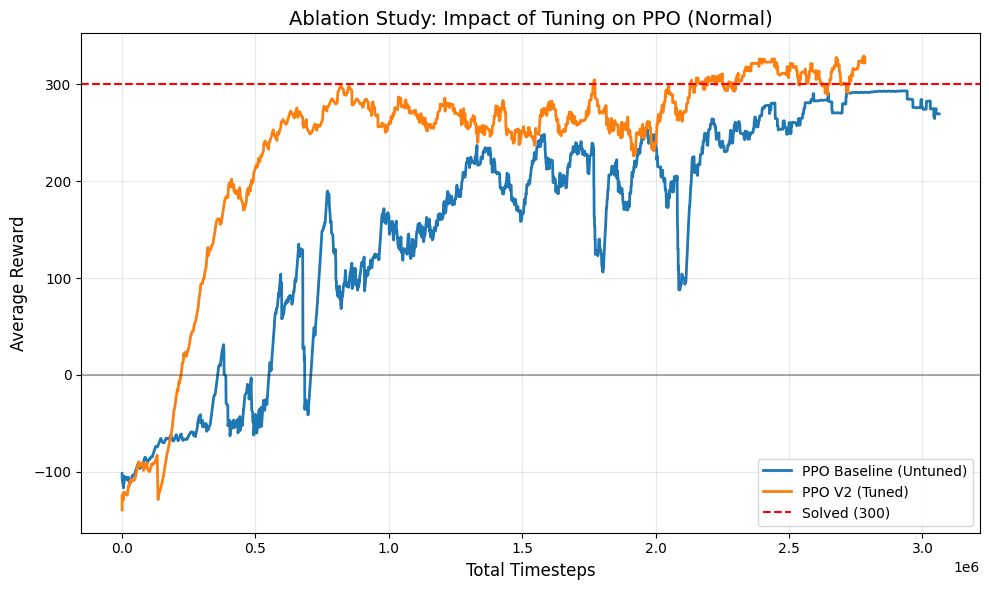


Generating Hardcore Difficulty Graph...


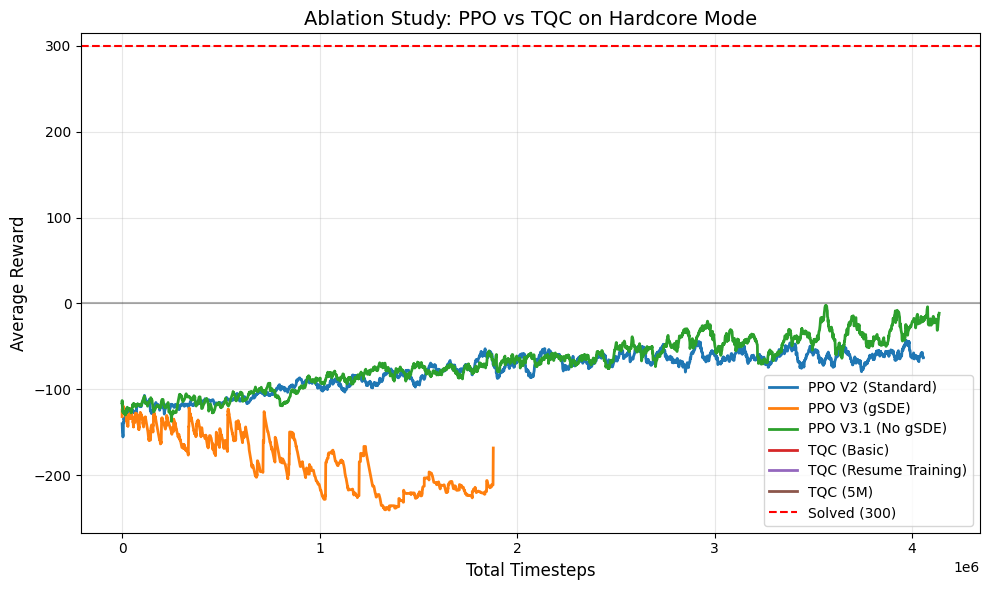

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
BASE_PATH = "/content/drive/MyDrive/aisf_project/logs"
SMOOTHING_WINDOW = 50000  # Smooths the jagged lines (Rolling average over 50k steps)

# Define your experiments groups
# Format: "Label for Legend": "Folder Name in Drive"
normal_experiments = {
    "PPO Baseline (Untuned)": "basic_ppo_final",
    "PPO V2 (Tuned)": "improved_ppo_v2"
}

hardcore_experiments = {
    "PPO V2 (Standard)": "improved_ppo_v2_hardcore",
    "PPO V3 (gSDE)": "sota_ppo_v3_hardcore",
    "PPO V3.1 (No gSDE)": "sota_ppo_v3_1_hardcore",
    "TQC (Basic)": "tqc_v3_hardcore",
    "TQC (Resume Training)": "tqc_v3_hardcore_finetune",
    "TQC (5M)": "tqc_v3_hardcore_5M" # Or whatever you named your final run
}

def load_data(experiment_name):
    """Loads monitor.csv and calculates cumulative steps."""
    log_path = os.path.join(BASE_PATH, experiment_name)

    # Find the monitor file (sometimes it's in a subfolder like 'PPO_1')
    monitor_file = None
    for root, dirs, files in os.walk(log_path):
        for file in files:
            if file.endswith("monitor.csv"):
                monitor_file = os.path.join(root, file)
                break
        if monitor_file: break

    if not monitor_file:
        print(f"Warning: No monitor.csv found for {experiment_name}")
        return None

    # Load CSV, skipping the first 2 metadata lines
    df = pd.read_csv(monitor_file, skiprows=1)

    # 'l' is episode length, 'r' is reward, 't' is wall time
    # We construct 'Total Timesteps' by cumsumming episode lengths
    if 'l' in df:
        df['timesteps'] = df['l'].cumsum()
        return df
    return None

def plot_experiments(experiment_dict, title, filename):
    plt.figure(figsize=(10, 6))

    for label, folder_name in experiment_dict.items():
        df = load_data(folder_name)
        if df is not None:
            # Smoothing
            # We use a rolling window to make the trend visible amidst the noise
            rolling_mean = df['r'].rolling(window=50, min_periods=1).mean()

            # Plot
            plt.plot(df['timesteps'], rolling_mean, label=label, linewidth=2)

            # Optional: Add shadow for variance (if you had multiple seeds, you'd calculate std here)
            # For single runs, we just plot the line.

    plt.axhline(y=300, color='r', linestyle='--', label='Solved (300)')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.title(f"Ablation Study: {title}", fontsize=14)
    plt.xlabel("Total Timesteps", fontsize=12)
    plt.ylabel("Average Reward", fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{filename}.png") # Saves to Colab so you can download
    plt.show()

# --- GENERATE PLOTS ---
print("Generating Normal Difficulty Graph...")
plot_experiments(normal_experiments, "Impact of Tuning on PPO (Normal)", "ablation_normal")

print("\nGenerating Hardcore Difficulty Graph...")
plot_experiments(hardcore_experiments, "PPO vs TQC on Hardcore Mode", "ablation_hardcore")

--- Generating Normal Difficulty Graph ---
✅ Plotted: PPO Baseline (Untuned)
✅ Plotted: PPO V2 (Tuned)


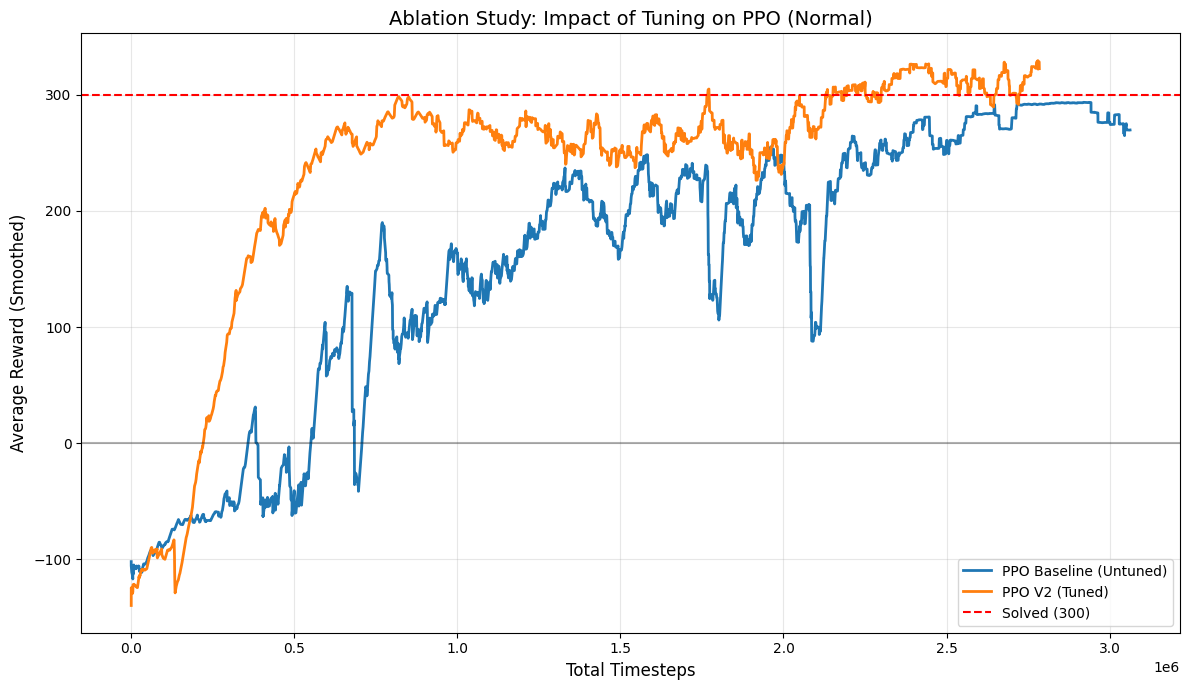


--- Generating Hardcore Difficulty Graph ---
✅ Plotted: PPO V2 (Standard)
✅ Plotted: PPO V3 (gSDE)
✅ Plotted: PPO V3.1 (No gSDE)
✅ Plotted: TQC (Basic 3M)
✅ Plotted: TQC (Finetuned +2M)
✅ Plotted: TQC (5M SOTA)


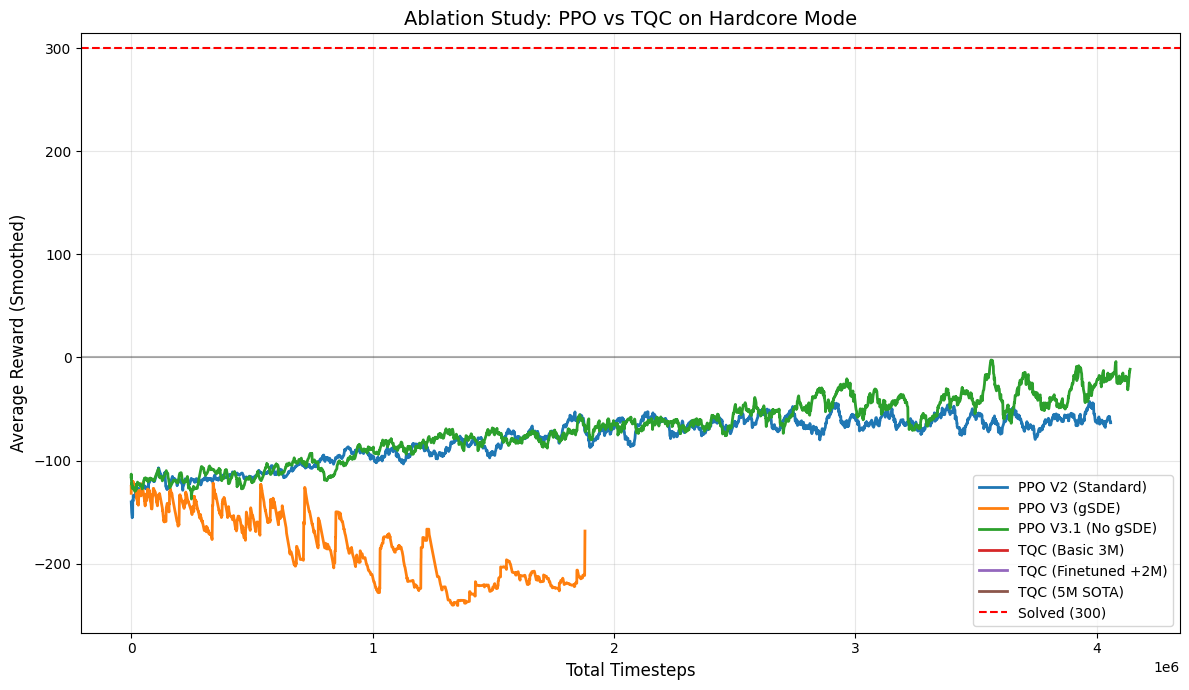

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
BASE_PATH = "/content/drive/MyDrive/aisf_project/logs"
SMOOTHING_WINDOW = 50  # Rolling average over 50 data points

# Define your experiments groups
# Format: "Label for Legend": "Folder Name in Drive"
normal_experiments = {
    "PPO Baseline (Untuned)": "basic_ppo_final",
    "PPO V2 (Tuned)": "improved_ppo_v2"
}

# UPDATED dictionary with correct folder names from your logs
hardcore_experiments = {
    "PPO V2 (Standard)": "improved_ppo_v2_hardcore",
    "PPO V3 (gSDE)": "sota_ppo_v3_hardcore",
    "PPO V3.1 (No gSDE)": "sota_ppo_v3_1_hardcore",
    "TQC (Basic 3M)": "tqc_v3_hardcore",        # Matches your first TQC run
    "TQC (Finetuned +2M)": "tqc_v3_hardcore_finetune", # Matches your resume run
    "TQC (5M SOTA)": "tqc_v3_hardcore_5M"           # Matches your final 5M run
}

def load_data(experiment_name):
    """Loads monitor.csv and calculates cumulative steps."""
    log_path = os.path.join(BASE_PATH, experiment_name)

    # Search for monitor.csv in subfolders (e.g., TQC_1)
    monitor_file = None
    if os.path.exists(log_path):
        for root, dirs, files in os.walk(log_path):
            for file in files:
                if file.endswith("monitor.csv"):
                    monitor_file = os.path.join(root, file)
                    break
            if monitor_file: break

    if not monitor_file:
        print(f"⚠️ Warning: Could not find data for '{experiment_name}'")
        return None

    try:
        # Load CSV, skipping the first 2 metadata lines
        df = pd.read_csv(monitor_file, skiprows=1)

        # 'l' is episode length, 'r' is reward
        # We construct 'Total Timesteps' by cumsumming episode lengths
        if 'l' in df and 'r' in df:
            df['timesteps'] = df['l'].cumsum()
            return df
    except Exception as e:
        print(f"Error reading {experiment_name}: {e}")

    return None

def plot_experiments(experiment_dict, title, filename):
    plt.figure(figsize=(12, 7))

    found_data = False
    for label, folder_name in experiment_dict.items():
        df = load_data(folder_name)
        if df is not None:
            found_data = True
            # Smoothing
            rolling_mean = df['r'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

            # Plot
            plt.plot(df['timesteps'], rolling_mean, label=label, linewidth=2)
            print(f"✅ Plotted: {label}")
        else:
            print(f"❌ Skipped: {label}")

    if found_data:
        plt.axhline(y=300, color='r', linestyle='--', label='Solved (300)')
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

        plt.title(f"Ablation Study: {title}", fontsize=14)
        plt.xlabel("Total Timesteps", fontsize=12)
        plt.ylabel("Average Reward (Smoothed)", fontsize=12)
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{filename}.png")
        plt.show()
    else:
        print(f"No data found for {title}. Check folder names in Drive.")

# --- GENERATE PLOTS ---
print("--- Generating Normal Difficulty Graph ---")
plot_experiments(normal_experiments, "Impact of Tuning on PPO (Normal)", "ablation_normal")

print("\n--- Generating Hardcore Difficulty Graph ---")
plot_experiments(hardcore_experiments, "PPO vs TQC on Hardcore Mode", "ablation_hardcore")

In [ ]:
import os
LOG_DIR = "/content/drive/MyDrive/aisf_project/logs"

print("--- Available Log Folders ---")
if os.path.exists(LOG_DIR):
    for folder in os.listdir(LOG_DIR):
        print(f"'{folder}'")
else:
    print(f"Error: Directory {LOG_DIR} not found!")

--- Available Log Folders ---
'basic_ppo_final'
'improved_ppo_v2'
'improved_ppo_v2_hardcore'
'sota_ppo_v3_hardcore'
'sota_ppo_v3_1_hardcore'
'tqc_hardcore_zoo_tuned'
'.ipynb_checkpoints'
'tqc_hardcore_zoo_tuned_gpu'
'tqc_hardcore_ultimate'
'tqc_v2_hardcore'
'tqc_v3_hardcore'
'tqc_v3_hardcore_finetune'
'tqc_v3_hardcore_5M'


  [Reading] Found 1 log file(s) in /content/drive/MyDrive/aisf_project/logs/improved_ppo_v2_hardcore...
  -> Plotted 367 points for PPO V2 (Tuned)
  [Reading] Found 1 log file(s) in /content/drive/MyDrive/aisf_project/logs/sota_ppo_v3_hardcore...
  -> Plotted 148 points for PPO V3 (SOTA gSDE)
  [Reading] Found 1 log file(s) in /content/drive/MyDrive/aisf_project/logs/sota_ppo_v3_1_hardcore...
  -> Plotted 367 points for PPO V3.1 (SOTA No-gSDE)
  [Reading] Found 2 log file(s) in /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore...
  -> Plotted 38 points for TQC (Initial)
  [Reading] Found 1 log file(s) in /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore_5M...
  -> Plotted 40 points for TQC (5M Winner)
  [Skipping] No TensorBoard files found in /content/drive/MyDrive/aisf_project/logs/tqc_v3_hardcore_finetune

Graph saved to hardcore_ablation_plot.png


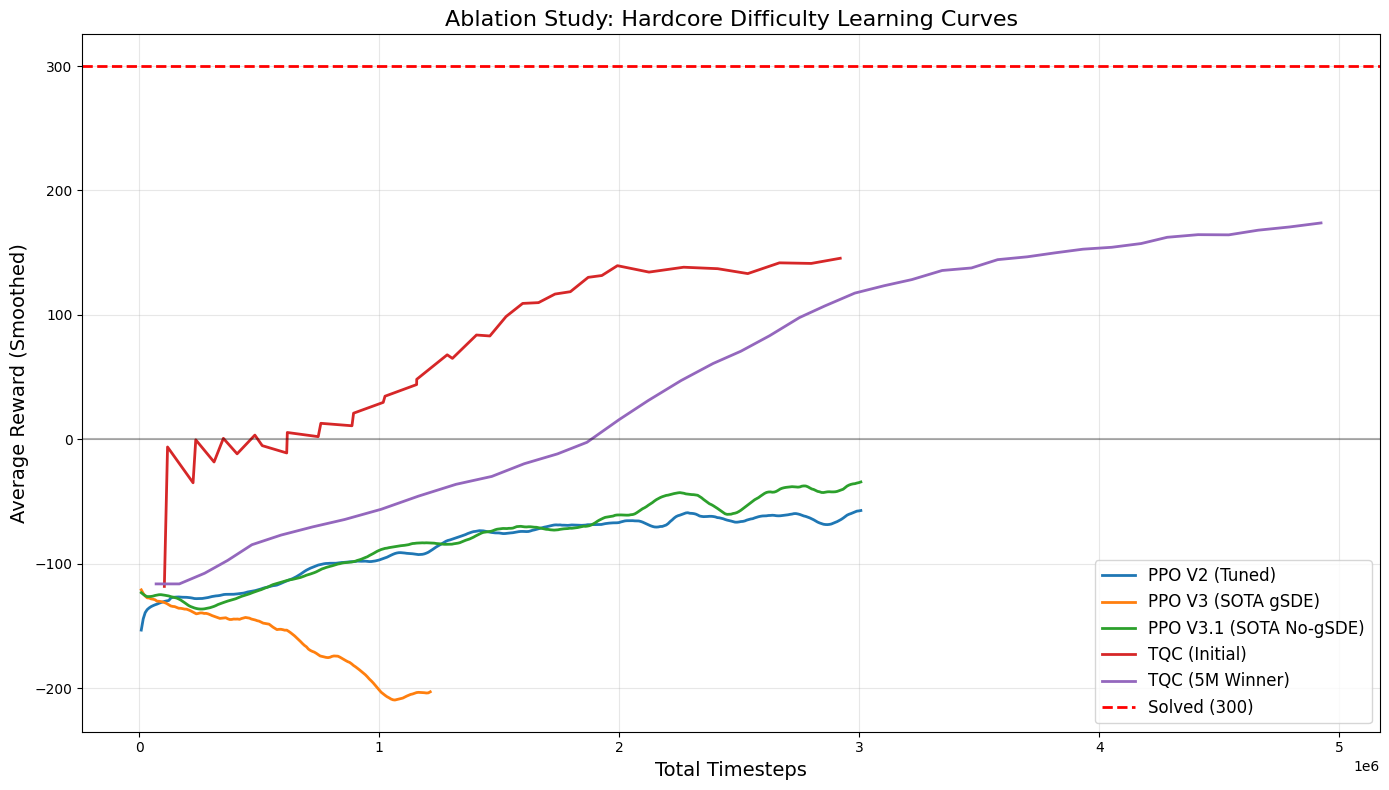

In [ ]:
# Install necessary library for reading TensorBoard files
!pip install pandas matplotlib tensorflow

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.core.util import event_pb2

# --- CONFIGURATION ---
BASE_PATH = "/content/drive/MyDrive/aisf_project/logs"
SMOOTHING_WINDOW = 15  # Smooths the line to make it readable

# Dictionary of your experiments
# keys = Legend Label, values = Folder Name in Drive
experiments = {
    "PPO V2 (Tuned)": "improved_ppo_v2_hardcore",
    "PPO V3 (SOTA gSDE)": "sota_ppo_v3_hardcore",
    "PPO V3.1 (SOTA No-gSDE)": "sota_ppo_v3_1_hardcore",
    "TQC (Initial)": "tqc_v3_hardcore",
    "TQC (5M Winner)": "tqc_v3_hardcore_5M",
    "TQC (Fine-Tuning)": "tqc_v3_hardcore_finetune"
}

def extract_tensorboard_data(log_dir):
    """
    Recursively finds all event files in a directory and extracts reward data.
    Returns a DataFrame with 'step' and 'reward'.
    """
    data = []

    # Find all event files recursively (e.g., inside TQC_1, PPO_1 subfolders)
    # This captures the data hidden inside the numbered subfolders
    event_files = glob.glob(f"{log_dir}/**/events.out.tfevents.*", recursive=True)

    if not event_files:
        print(f"  [Skipping] No TensorBoard files found in {log_dir}")
        return None

    print(f"  [Reading] Found {len(event_files)} log file(s) in {log_dir}...")

    for file_path in event_files:
        try:
            # Create an iterator to read the binary event file
            iterator = tf.data.TFRecordDataset(file_path)

            for record in iterator:
                event = event_pb2.Event.FromString(record.numpy())
                for value in event.summary.value:
                    # 'rollout/ep_rew_mean' is the standard tag for mean reward
                    if value.tag == "rollout/ep_rew_mean":
                        data.append({
                            "step": event.step,
                            "reward": value.simple_value
                        })
        except Exception as e:
            print(f"  ! Error reading file {os.path.basename(file_path)}")

    if not data:
        return None

    # Create DataFrame and sort by step so the line draws correctly
    df = pd.DataFrame(data).sort_values("step")
    return df

# --- PLOTTING ---
plt.figure(figsize=(14, 8))

for label, folder_name in experiments.items():
    full_path = os.path.join(BASE_PATH, folder_name)

    df = extract_tensorboard_data(full_path)

    if df is not None and not df.empty:
        # Smoothing
        df["smoothed_reward"] = df["reward"].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

        # Plot
        plt.plot(df["step"], df["smoothed_reward"], label=label, linewidth=2)
        print(f"  -> Plotted {len(df)} points for {label}")

# --- FORMATTING ---
plt.axhline(y=300, color='r', linestyle='--', linewidth=2, label='Solved (300)')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.title("Ablation Study: Hardcore Difficulty Learning Curves", fontsize=16)
plt.xlabel("Total Timesteps", fontsize=14)
plt.ylabel("Average Reward (Smoothed)", fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and Show
save_path = "hardcore_ablation_plot.png"
plt.savefig(save_path, dpi=300)
print(f"\nGraph saved to {save_path}")
plt.show()

In [3]:
!apt-get install -y swig ffmpeg xvfb
!pip install gymnasium[box2d] stable-baselines3 shimmy pyvirtualdisplay sb3-contrib
import gymnasium as gym
import pandas as pd
import os
import numpy as np
from sb3_contrib import TQC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

# --- CONFIGURATION ---
base_path = "/content/drive/MyDrive/aisf_project"
models_dir = f"{base_path}/models"
logs_dir = f"{base_path}/logs"

# 1. PPO Experiments (Read from Logs if available, as they are likely unchanged)
ppo_experiments = {
    "basic_ppo_final": "PPO Baseline (Normal)",
    "improved_ppo_v2": "PPO Tuned (Normal)",
    "sota_ppo_v3_hardcore": "PPO SOTA (Hardcore)",
    "sota_ppo_v3_1_hardcore": "PPO Hybrid (Hardcore)"
}

# 2. TQC Experiments (Will be RETESTED Live)
tqc_experiments = [
    "tqc_v3_hardcore",
    "tqc_v3_hardcore_5M",
    "tqc_v3_hardcore_finetune"
]

# --- HELPER: GET STATS FROM OLD LOGS (PPO) ---
def get_log_stats(exp_name, label):
    path = os.path.join(logs_dir, exp_name, "monitor.csv")
    if not os.path.exists(path):
        return {"Experiment": label, "Final Score": "N/A (Log Missing)", "Result": "Unknown"}

    try:
        df = pd.read_csv(path, skiprows=1)
        final_mean = df['r'].iloc[-100:].mean()
        # Infer Result
        if final_mean > 290: result = "Solved"
        elif final_mean < 100: result = "Failed"
        else: result = "Converged/Stuck"

        return {
            "Experiment": label,
            "Final Score": round(final_mean, 2),
            "Result": result
        }
    except:
        return {"Experiment": label, "Final Score": "Error", "Result": "Error"}

# --- HELPER: LIVE RETEST (TQC) ---
def retest_tqc(exp_name):
    print(f"--- Retesting {exp_name} (Live Evaluation)...")

    model_path = os.path.join(models_dir, exp_name, "final_model.zip")
    stats_path = os.path.join(models_dir, exp_name, "vec_normalize.pkl") # Standard name

    # Fallback for stats naming if 'vec_normalize.pkl' doesn't exist
    if not os.path.exists(stats_path):
        stats_path = os.path.join(models_dir, exp_name, "vecnormalize.pkl")

    if not os.path.exists(model_path):
        return {"Experiment": exp_name, "Final Score": "Model Not Found", "Result": "N/A"}

    # 1. Create Env
    env = gym.make("BipedalWalkerHardcore-v3")
    env = DummyVecEnv([lambda: env])

    # 2. Load Stats (Crucial)
    if os.path.exists(stats_path):
        print(f"   Loaded normalization stats from {os.path.basename(stats_path)}")
        env = VecNormalize.load(stats_path, env)
        env.training = False
        env.norm_reward = False
    else:
        print("   WARNING: No normalization stats found! Score may be incorrect.")

    # 3. Load Model
    try:
        model = TQC.load(model_path)
    except:
        return {"Experiment": exp_name, "Final Score": "Load Error", "Result": "Error"}

    # 4. Run Evaluation (100 Episodes)
    # This gives the most scientifically accurate "Current Performance"
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

    env.close()

    # Logic for "Result" column
    if mean_reward > 295: result = "Solved (Perfect)"
    elif mean_reward > 250: result = "Solved (Robust)"
    elif mean_reward > 200: result = "Converging"
    else: result = "Failed"

    return {
        "Experiment": exp_name,
        "Final Score": f"{mean_reward:.2f} +/- {std_reward:.2f}",
        "Result": result
    }

# --- MAIN EXECUTION ---
all_stats = []

# 1. Process PPO (Fast, from logs)
for exp, label in ppo_experiments.items():
    all_stats.append(get_log_stats(exp, label))

# 2. Process TQC (Slow, accurate retest)
for exp in tqc_experiments:
    all_stats.append(retest_tqc(exp))

# 3. Generate Table
df = pd.DataFrame(all_stats)
print("\n" + "="*60)
print("FINAL ABLATION RESULTS (Paste into Writeup)")
print("="*60)
print(df.to_markdown(index=False))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
  Using cached stable_baselines3-2.7.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached Shimmy-2.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached PyVirtualDisplay-3.0-py3-none-any.whl.metadata (943 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.4 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl siz

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Retesting tqc_v3_hardcore (Live Evaluation)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_r

   Loaded normalization stats from vec_normalize.pkl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Retesting tqc_v3_hardcore_5M (Live Evaluation)...
   Loaded normalization stats from vec_normalize.pkl
--- Retesting tqc_v3_hardcore_finetune (Live Evaluation)...
   Loaded normalization stats from vec_normalize.pkl

FINAL ABLATION RESULTS (Paste into Writeup)
| Experiment               | Final Score       | Result          |
|:-------------------------|:------------------|:----------------|
| PPO Baseline (Normal)    | 271.98            | Converged/Stuck |
| PPO Tuned (Normal)       | 319.27            | Solved          |
| PPO SOTA (Hardcore)      | -195.16           | Failed          |
| PPO Hybrid (Hardcore)    | -18.43            | Failed          |
| tqc_v3_hardcore          | 175.62 +/- 130.53 | Failed          |
| tqc_v3_hardcore_5M       | 178.28 +/- 141.84 | Failed          |
| tqc_v3_hardcore_finetune | 208.97 +/- 116.59 | Converging      |


In [4]:
# Create a clean requirements file
content = """gymnasium[box2d]
stable-baselines3[extra]
shimmy>=0.2.1
box2d-py==2.3.8
numpy
pandas
matplotlib
seaborn
"""
with open("requirements.txt", "w") as f:
    f.write(content)
print("requirements.txt created!")

requirements.txt created!
